 # Homework 5
 
 ## Yakup Can Karacaoğlu

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spa
from scipy.stats import multivariate_normal
import scipy.stats as stats

## Import Data

In [2]:
# read data into memory
data_set = np.genfromtxt("hw05_data_set.csv", delimiter = ",")

# read the initial centroids
centroids = np.genfromtxt("hw05_initial_centroids.csv", delimiter = ",")

# number of data points 
N = data_set.shape[0]
D = data_set.shape[1]

## Parameters

In [3]:
# cluster count
K = 5
# number of iterations 
iterations = 100

## Algorithm Steps

In [4]:
def update_memberships(centroids, X):
    # calculate distances between centroids and data points
    D = spa.distance_matrix(centroids, X)
    # find the nearest centroid for each data point
    memberships = np.argmin(D, axis = 0)
    return(memberships)
def calculate_covariances(X, clusters):
    covariances = []
    for k in range(K):
        # Select all data points in cluster k
        X_k = X[clusters == k, :]
        mean_k = np.mean(X_k, axis=0)
        cov_k = np.zeros((D, D))
        for i in range(X_k.shape[0]):
            cov_k += np.outer(X_k[i] - mean_k, X_k[i] - mean_k)
        cov_k /= X_k.shape[0] - 1
        covariances.append(cov_k)
        
    return covariances

def E_step(centroids, covariances, priors, X):
    H = np.zeros((N,K))
    for i in range(N):
        denum = 0
        for k in range(K):
            denum += stats.multivariate_normal.pdf(X[i], centroids[k], covariances[k], allow_singular=True) * priors[k]
        for k in range(K):
            H[i][k] = stats.multivariate_normal.pdf(X[i], centroids[k], covariances[k],allow_singular=True) * priors[k] / denum

    return H


def M_step(H):
    prior = np.zeros((5,1))
    centroids = []
    for k in range(K):
        h_i_k = 0
        h_i_k_x = 0
        for i in range(N):
            h_i_k += H[i][k];
            h_i_k_x += H[i][k] * data_set[i]
        prior[k] = h_i_k / N
        centroids.append(h_i_k_x / h_i_k)
        
    covariances = np.zeros(shape=(K, 2, 2))
    for k in range(K):
        covariances[k] = np.array([[0,0],[0,0]])
        for i in range(N):
            covariances[k] += (H[i,k] * np.matmul((data_set[i] - centroids[k]).reshape(-1,1), (data_set[i] - centroids[k]).reshape(1,-1)))
        covariances[k] = covariances[k] / np.sum(H[:,k])
    return np.asarray(centroids),covariances,prior
    

## Initialize EM

In [5]:
#Estimate to the nearest
memberships = update_memberships(centroids,data_set)
covariances = calculate_covariances(data_set,memberships)
priors = [data_set[memberships == k].shape[0] / N for k in range(K)]
print("Initial Class Covariances:\n", np.asarray(covariances))
print("Initial Prior Probabilities:\n", priors)

Initial Class Covariances:
 [[[ 4.10651975  0.12968282]
  [ 0.12968282  0.48250308]]

 [[ 3.34978607 -2.71802273]
  [-2.71802273  4.4759659 ]]

 [[ 5.48635191  3.26628461]
  [ 3.26628461  4.30200025]]

 [[ 2.45118028  0.0569932 ]
  [ 0.0569932   1.70303234]]

 [[ 3.56803974 -2.94725544]
  [-2.94725544  7.77035015]]]
Initial Prior Probabilities:
 [0.063, 0.156, 0.283, 0.223, 0.275]


## Iterations

In [6]:
for i in range(iterations):
    H = E_step(centroids, covariances, priors, data_set)
    centroids, covariances, priors = M_step(H)

In [7]:
print("print(means)")
print(centroids)

print(means)
[[ 0.15012647 -0.10601062]
 [ 5.63782309 -0.01720488]
 [-0.06077502 -5.60092697]
 [-0.08487478  5.45469879]
 [-5.4828878  -0.08822559]]


## Plotting

In [8]:
class_means = np.zeros((K,2))
class_cov = np.zeros((K, 2, 2))

class_means[0] = [+0.0, +5.5]
class_means[1] = [-5.5, +0.0]
class_means[2] = [+0.0, +0.0]
class_means[3] = [+5.5, +0.0]
class_means[4] = [+0.0, -5.5]


class_cov[0] = [[+4.8, +0.0], [+0.0, +0.4]]
class_cov[1] = [[+0.4, +0.0], [+0.0, +2.8]]
class_cov[2] = [[+2.4, +0.0], [+0.0, +2.4]]
class_cov[3] = [[+0.4, +0.0], [+0.0, +2.8]]
class_cov[4] = [[+4.8, +0.0], [+0.0, +0.4]]

def plot_current_state(centroids, memberships, X):
    cluster_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#b15928",
                               "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99"])
    if memberships is None:
        plt.plot(X[:, 0], X[:, 1], ".", markersize = 10, color = "black")
    else:
        for c in range(K):
            plt.plot(X[memberships == c, 0], X[memberships == c, 1], ".", markersize = 10,
                     color = cluster_colors[c])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    x1_grid, x2_grid = np.meshgrid(np.linspace(-8, +8, 1601), np.linspace(-8, +8, 1601))
    intervals = np.dstack((x1_grid, x2_grid))

    for k in range(K):
        em_points = stats.multivariate_normal(centroids[k],covariances[k]).pdf(intervals)
        plt.contour(x1_grid, x2_grid, em_points, colors=cluster_colors[k], levels=[0.05])
        given_points = stats.multivariate_normal(class_means[k], class_cov[k]).pdf(intervals)
        plt.contour(x1_grid, x2_grid, given_points, linestyles='dashed', levels=[0.05], colors='k')
    
    

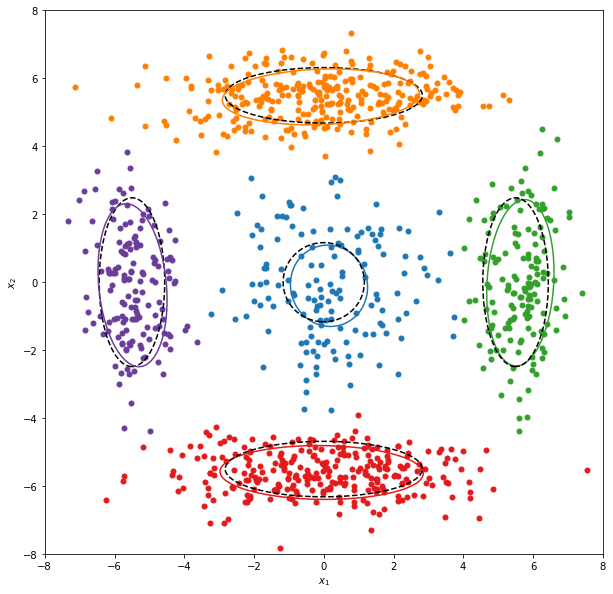

In [10]:
plt.figure(figsize=(10, 10))
plot_current_state(centroids,np.argmax(H,axis=1),data_set)
plt.show()